In [40]:
#/usr/bin/python3

# -*- coding: utf-8 -*-
"""
@author: taccone
"""
# Script for plotting and averaging HeDrop IR spectra #

'\n@author: taccone\n'

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import os
from scipy import interpolate
import collections
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import linregress

In [42]:
def pages(spectra):
    """
    Function to add each plot to a page of a pdf file
    """
    # Getting the data from .dat file
    data = pd.read_csv(data_path + '/' + spectra, delimiter="	")
    if len(data.columns) == 7:
        data.columns = ['freq','Energy','FWHM','WN', 'Pyro', 'TOF1', 'TOF2'] # one TOF2 channel
    elif len(data.columns) == 8:
        data.columns = ['freq','Energy','FWHM','WN', 'Pyro', 'TOF1', 'TOF2', 'TOF2_2'] # two TOF2 channels
    elif len(data.columns) == 9:
        data.columns = ['freq','Energy','FWHM','WN', 'Pyro', 'TOF1', 'TOF2', 'TOF2_2', 'TOF2_3'] # three TOF2 channels
    elif len(data.columns) == 10:
        data.columns = ['freq','Energy','FWHM','WN', 'Pyro', 'TOF1', 'TOF2', 'TOF2_2', 'TOF2_3', 'TOF2_4'] # four TOF2 channels

    # Creating figure
    fig, axis1 = plt.subplots(figsize=(12,8), dpi= 100)

    # IR plot details
    color = 'black'
    axis1.set_xlabel("Wavenumber [cm-1]", fontsize=18)
    axis1.set_ylabel("Intensity", color=color, fontsize=18)
    axis1.tick_params(axis='both', labelcolor=color, labelsize=18)
    axis1.set_xlim(xmin=lower_xlim,xmax=upper_xlim)
    
    # TOF2 channel to plot
    axis1.plot(wn, data.TOF2, color=color)
    #axis1.plot(wn, data.TOF2_2, color=color)
    #axis1.plot(wn, data.TOF2_3, color=color)
    #axis1.plot(wn, data.TOF2_4, color=color)

    # Instantiate a second axes that shares the same x-axis (FEL power plot)
    axis2 = axis1.twinx()
    color = 'tab:blue'
    axis2.set_ylabel("FEL power [mJ]", color=color, fontsize=18)  # we already handled the x-label with ax1
    axis2.plot(wn, data.Energy, color=color)
    axis2.tick_params(axis='both', labelcolor=color, labelsize=18)
    axis2.set_ylim([lower_ylim_Energy,upper_ylim_Energy]) # limiter for y-axis of FEL power
    axis2.set_xlim(xmin=lower_xlim,xmax=upper_xlim)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    # Plot title (.dat file name)
    plt.title(spectra, fontsize=12)

    # Print 'Crashed at ..' if the spectra_dict value is not 'None'
    if spectra_dict.get(spectra) != None:
        # Position of the text
        plt.text(lower_xlim+10, upper_ylim_Energy-upper_ylim_Energy*0.1, str(spectra_dict.get(spectra)), size=16)

    # Saving figures on pdf page
    return pdf.savefig(fig)

In [43]:
def input_data(data, xmin, xmax, npoints, fill):
    """
    Input for spectra averaging
    """
    # Wavenumber column
    #wn = data[:,3]
    wn = linreg(data)
    # Intensity column (remember python start counting from 0)
    intensity = data[:,6]
    xint = np.linspace(xmin, xmax, npoints)
    interp = interpolate.interp1d(wn, intensity, bounds_error = False, fill_value = (fill, fill), kind = "slinear")
    yint = interp(xint)
    return xint, yint

def ppoly(data):
    """
    Define polynomial fit for power curve
    """
    # Wavenumber column
    #wn = data[:,3]
    wn = linreg(data)
    # FEL power column
    power = data[:,1]
    # Fitting the power curve
    fit = np.polyfit(wn, power, 3)
    return fit

def linreg(data):
    """
    Linear fit between desired wn range (data[:,0]) and calculated wn (data[:,3])
    Every spectra if plotted against the fitted wn
    """
    points_for_fit = []
    reg_test = linregress(data[:,0],data[:,3]) # lin fit for checking
    for i in range(len(data[:,0])):
        if abs(data[i,3] - ((data[i,0] * reg_test.slope) + reg_test.intercept)) <= 1.0:  # discard points that are 1 cm-1 away from the fit
            points_for_fit.append([data[i,0], data[i,3]])
    reg = linregress(points_for_fit) # final lin fit
    fitted_wn = (data[:,0] * reg.slope) + reg.intercept
    return fitted_wn

In [44]:
# Data path | replace for r'PATH\\' if you use Windows path 
data_path = '/home/martint/Desktop/FHI/hedrop-project'

## CHOOSE ONE OPTION ##

# Plotting every spectra in the folder
keys = []
values = []
spectra_dict = {}

for file in os.listdir(data_path):
    if file.startswith("0"):
        if file.endswith(".dat"):
            keys.append(file)
            values.append(None)
for i in range(len(keys)):
    spectra_dict[keys[i]] = values[i]

spectra_dict = {keys[i]: values[i] for i in np.argsort(keys)}
pd.options.display.max_colwidth = 100
print(pd.DataFrame.from_dict(spectra_dict, orient='index'))

# All spectra plot | You can add text in the value of each key (i.e. instead of None) as "SOME TEXT"
#spectra_dict = {"016-12C4H _mz177-ch7_H-ch8_D-1360_1610-19K_5.0V_coldtrap_MCP2-1650V_33atte_20230214_001237.dat": None,
#                "017-12C4H _mz177-ch7_H-ch8_D-1360_1610-19K_5.0V_coldtrap_MCP2-1650V_33atte_20230214_004724.dat": None,
#                "004-12C4H _mz177-ch7_H-ch8_D-1450_1540-19K_4.5V_coldtrap_MCP2-1650V_50atte_20230213_130840.dat": None,
#                "005-12C4H _mz177-ch7_H-ch8_D-1450_1700-19K_5.0V_coldtrap_MCP2-1650V_50atte_20230213_132406.dat": None,
#                "006-12C4H _mz177-ch7_H-ch8_D-1680_1800-19K_5.0V_coldtrap_MCP2-1650V_50atte_20230213_135903.dat": 1300,
#                "007-12C4H _mz177-ch7_H-ch8_D-880_1450-19K_5.0V_coldtrap_MCP2-1650V_50atte_20230213_153340.dat": None,
#                }

                                                                                                     0
012-12C4H _mz177-ch7_H-ch8_D-1800_800-19K_5.0V_coldtrap_MCP2-1650V_50 33atte_20230213_204235.dat  None


In [45]:
# Upper and lower limits of the x-axis in the plot
lower_xlim = 800
upper_xlim = 1800

# Upper and lower limits of the FEL power y-axis in the plot
lower_ylim_Energy = 0
upper_ylim_Energy = 100

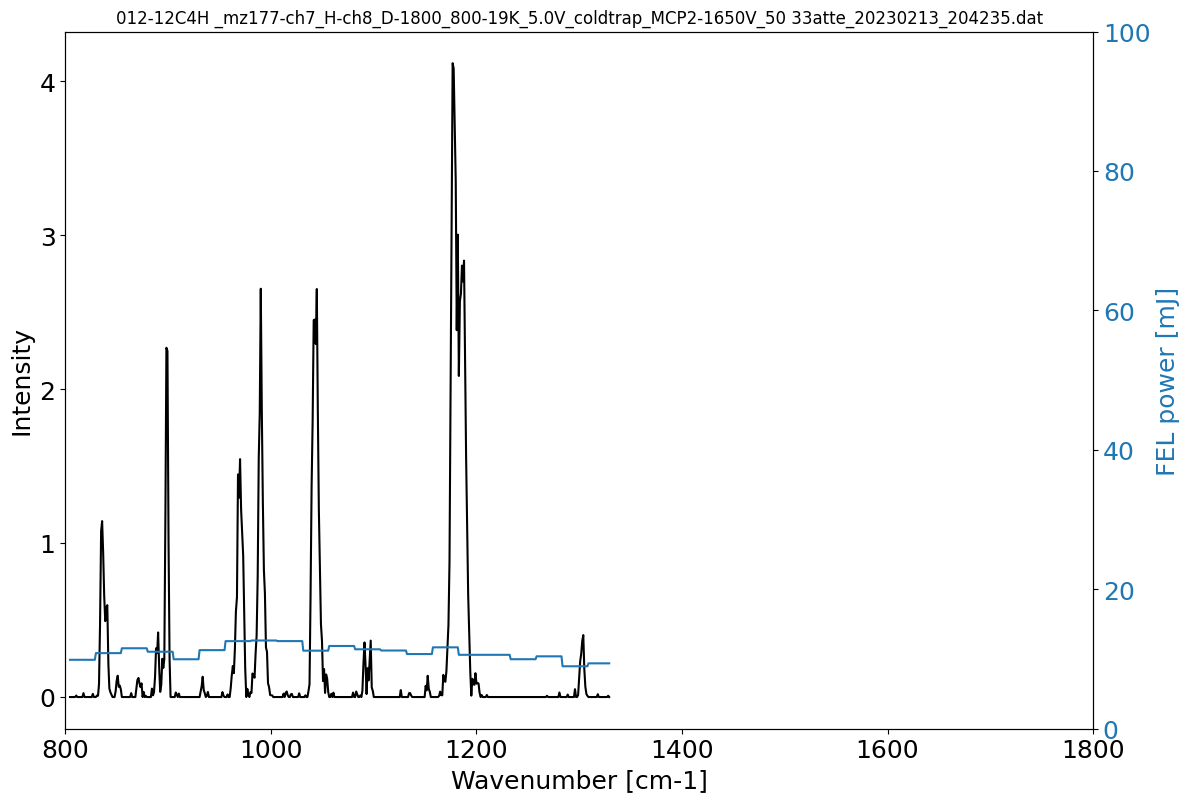

In [46]:
# Instantiating PDF document
pdf = PdfPages('spectra_plots_all.pdf')

# Loop over spectra and call function
for spectra,xmax in spectra_dict.items():
    wn = linreg(data)
    pages(spectra)
    
    # Writting data to pdf file
pdf.close()

In [47]:
# Averaging spectra
# Max range measured (make mask after for shorter scans)
xmin = 800
xmax = 1800

# Number of points
npoints = xmax - xmin + 2

# Mask filling parameter
fill = 20.0

# Spectra to be used (format: "filename": xmax)
# If laser crashed but scan continued put the last measured value in xmax
#spectra_dict = {data_path + "010-12C4H _mz177-ch7_H-ch8_D-1150_1200-19K_5.0V_coldtrap_MCP2-1650V_50 33atte_20230213_191240.dat": None,
#                data_path + "011-12C4H _mz177-ch7_H-ch8_D-1050_800-19K_5.0V_coldtrap_MCP2-1650V_50 33atte_20230213_200322.dat": None,
#             }

# Loop over spectra files
# Load .dat file and interpolate. Outside the range, the y-values are set to the variable "fill"
intensity_data = []
for spectra, max_x in spectra_dict.items():
    data = np.loadtxt(data_path + '/' + spectra, skiprows=1)
    wn, intensity = input_data(data, xmin, xmax, npoints, fill)

    # Make cubic polynomial fit to the power curve
    fit = ppoly(data)
    power = np.poly1d(fit)
    
    # Divide by the laser power
    intensity_corr = (intensity/power(wn))*wn
    
    # First value of Wavenumber column
    #xdatamin = data[0,3]
    xdatamin = linreg(data)[0]
    
    # If a value was given in spectra_dict use it, else use the last value of Wavenumber column
    if max_x is not None:
        xdatamax = max_x
    else:
        #xdatamax = data[len(data[:,3])-1,3]
        xdatamax = linreg(data)[len(linreg(data))-1]
        
    # Create a mask for values ouside the measured range
    marray = np.logical_xor(wn > xdatamin, wn < xdatamax)
    
    # Append the masked spectra into ydata list
    intensity_data.append(np.ma.masked_array(intensity_corr, marray))

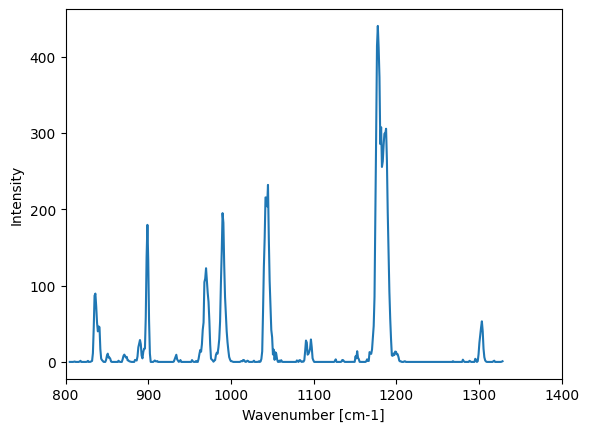

In [48]:
# Average data
average = np.ma.mean(intensity_data, axis=0)

# Plot data. Access individual spectrum by intensity_data list
spectra_to_plot = [0]
for i in spectra_to_plot:
    plt.plot(wn, intensity_data[i])

# Plot details
plt.xlabel("Wavenumber [cm-1]")
plt.ylabel("Intensity")
#plt.ylim(0,1000) # Intensity limits
plt.xlim(800,1400) # wn limits

#plt.plot(wn, average)
plt.show()

# Save final average in xy format
np.savetxt(data_path + '/spectra_average.dat', np.vstack((wn, average)).T, delimiter=' ')